### Mushroom: Poisonous vs. Edible

In [15]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams, gridspec
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

In [16]:
df = pd.read_csv('mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [17]:
#Look into df for datatypes, if nulls exist
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 non-null object
ring-number

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [18]:
df_dum = pd.get_dummies(df, drop_first=True)
df_dum.head()

,class_p,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_c,...,population_n,population_s,population_v,population_y,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [51]:
# set features
X = df_dum.drop('class_p', axis=1)
# set independent variable
y = df_dum['class_p']
#split the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

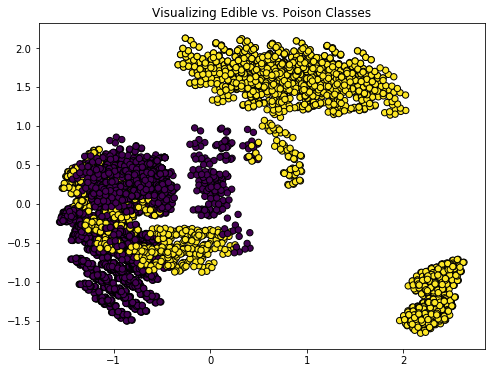

In [44]:
#visualize edible vs poison classes
pca = PCA(n_components=2)

x_pca = X.values
x_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=y, s=40, edgecolor='k')
plt.title('Visualizing Edible vs. Poison Classes');

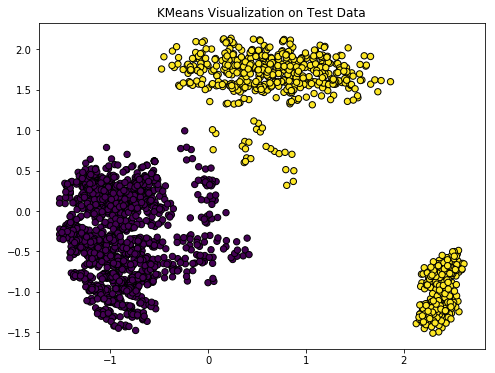

In [45]:
from sklearn import metrics
from sklearn.cluster import KMeans

#Specify the model
km = KMeans(n_clusters = 2)
#PCA X_test for visualization
pca_test = PCA(n_components=2)
pca_test.fit(X_test)
X_test_pca = X_test.values
X_test_pca = pca_test.fit_transform(X_test)
#Fit the model to the data
km.fit(X_train);

#Annotate the data points with the KMeans prediction
y_pred_km = km.predict(X_test)

#Plot the data:
plt.figure(figsize=(8,6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred_km, 
            s=40, edgecolor='k')
plt.title('KMeans Visualization on Test Data')
plt.show();

In [46]:
def plot_confusion_matrix(cm, classes, fontsize=15,
                          normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm_num = cm
    cm_per = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title.replace('_',' ').title()+'\n', size=fontsize)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=fontsize)
    plt.yticks(tick_marks, classes, size=fontsize)

    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Set color parameters
        color = "white" if cm[i, j] > thresh else "black"
        alignment = "center"

        # Plot perentage
        text = format(cm_per[i, j], '.5f')
        text = text + '%'
        plt.text(j, i,
            text,
            fontsize=fontsize,
            verticalalignment='baseline',
            horizontalalignment='center',
            color=color)
        # Plot numeric
        text = format(cm_num[i, j], 'd')
        text = '\n \n' + text
        plt.text(j, i,
            text,
            fontsize=fontsize,
            verticalalignment='center',
            horizontalalignment='center',
            color=color)
        
    plt.tight_layout()
    plt.ylabel('True label'.title(), size=fontsize)
    plt.xlabel('Predicted label'.title(), size=fontsize)

    return None

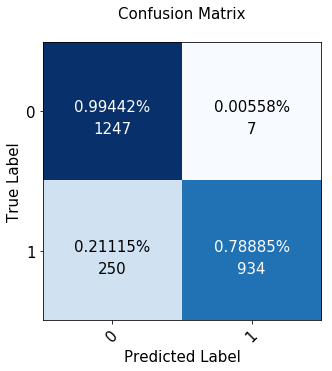

In [47]:
cm_km = metrics.confusion_matrix(y_test,y_pred_km)
plot_confusion_matrix(cm_km, classes=[0,1])

In [48]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_km)

0.894585726004922

In [173]:
sel = VarianceThreshold(threshold=0.1)
Xfixed = sel.fit_transform(X)
print(sel.variances_)

[0.00049213 0.23745291 0.0915325  0.00392343 0.24750246 0.00049213
 0.21563549 0.23986166 0.00538672 0.15054688 0.17519196 0.2021013
 0.01741107 0.00196559 0.00196559 0.11162772 0.11454266 0.24286969
 0.02307513 0.1951873  0.04681256 0.00441168 0.24567941 0.03051859
 0.06587408 0.06587408 0.02518115 0.13541558 0.21359814 0.0116772
 0.08399692 0.08198478 0.04769936 0.11235937 0.00781583 0.14992481
 0.00294548 0.05689363 0.12606549 0.01047386 0.24548305 0.24876065
 0.06375527 0.11885688 0.02307513 0.20672535 0.23119685 0.00294548
 0.20317283 0.23842601 0.03373608 0.00441168 0.0116772  0.06587408
 0.05210425 0.02307513 0.17733113 0.24755143 0.00098377 0.00441168
 0.0116772  0.06587408 0.05905122 0.02307513 0.17733113 0.24842902
 0.00294548 0.0116772  0.02401235 0.00098377 0.07215777 0.06840065
 0.00587351 0.13407836 0.00441168 0.24986612 0.16053097 0.17733113
 0.18356246 0.00587351 0.00878408 0.00587351 0.20754087 0.00587351
 0.04009977 0.04681256 0.13002014 0.24999267 0.16632497 0.194493

Next, Logistic Regression

In [54]:
#logistic regression
log_model = linear_model.LogisticRegression()
log_model.fit(X_train, y_train)
log_probs = log_model.predict_proba(X_test)
loss = log_loss(y_test, log_probs)
print('Loss value: {}'.format(loss))
print('Training accuracy: {}%'.format(log_model.score(X_train, y_train)))
print('Test accuracy: {}%'.format(log_model.score(X_test, y_test)))

Loss value: 0.008853782721418119
Training accuracy: 0.9996482588814632%
Test accuracy: 0.9987694831829368%


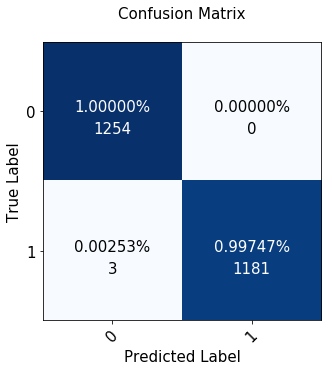

In [59]:
import seaborn as sns
from sklearn import metrics

predictions = log_model.predict(X_test)

cm = metrics.confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, [0,1])

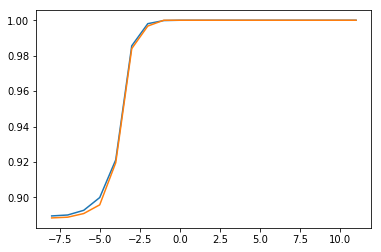

<Figure size 864x576 with 0 Axes>

In [60]:
#SVM checking C
train = []
test = []

value_range = [0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,\
               1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000,100000000000]
#loop through vaues of C
for i in value_range :
    SVM_model = LinearSVC(C=i)
    SVM_model.fit(X_train, y_train)
    train.append(SVM_model.score(X_train, y_train))
    test.append(SVM_model.score(X_test, y_test))

#plot out results
plt.plot(np.log10(value_range),train)
plt.plot(np.log10(value_range),test)
plt.figure(figsize=(12,8))
plt.show();

In [64]:
#fit SVM model to scaled data
SVM_model = LinearSVC(C=0.001)
SVM_model.fit(X_train, y_train)
print('The normalized training accuracy is: {}%'.format(SVM_model.score(X_train, y_train)))
print('The normalized test accuracy is: {}%'.format(SVM_model.score(X_test, y_test)))

The normalized training accuracy is: 0.9855786141399929%
The normalized test accuracy is: 0.9840032813781788%


In [67]:
#test out different SVMs using the different kernals
kerns = ['linear', 'rbf', 'sigmoid']
for i in kerns:
    #Kernel trick
    my_kernel_SVM = SVC(C=0.01, kernel='{}'.format(i))
    my_kernel_SVM.fit(X_train,y_train)
    
    #Get the score
    print('{0} Kernal SVM score: {1}'.format(i, (100*my_kernel_SVM.score(X_test,y_test))))

linear Kernal SVM score: 98.44134536505332
rbf Kernal SVM score: 89.78671041837572
sigmoid Kernal SVM score: 89.49958982772765


In [68]:
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
xgb = XGBClassifier()

gb.fit(X_train,y_train)
xgb.fit(X_train,y_train)

print("Gradient Boost score: %3.3f" % (100 * gb.score(X_test,y_test)))
print("XG Boost score: %3.3f"       % (100 * xgb.score(X_test,y_test)))

Gradient Boost score: 100.000
XG Boost score: 100.000


c:\users\b\venv\tensor35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


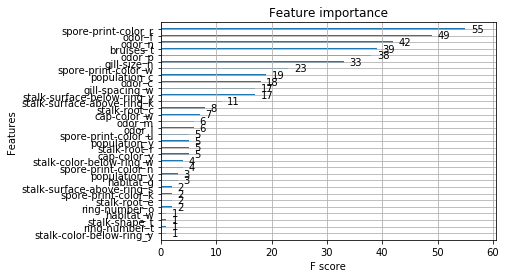

In [70]:
from xgboost import plot_importance
#look at features of 
xgb.feature_importances_
plot_importance(xgb)
plt.show()

In [74]:
#testing out random forest  
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
print("Default RFR: %3.3f" % (rf.score(X_test, y_test)))

Default RFR: 1.000


In [ ]:
param_grid = { 
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [82]:
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy'], 'n_estimators': [100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [76]:
rfcv = RandomForestClassifier(criterion= 'gini',
 max_depth= 5,
 max_features= 'auto',
 n_estimators= 100)
rfcv.fit(X_train, y_train)
print("Default RFR: %3.3f" % (rfcv.score(X_test, y_test)))

Default RFR: 0.989


In [87]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 100}

In [99]:
print (np.mean(cross_val_score(SVM_model, X_train, y_train, cv=100)))

0.9336247947454843


In [152]:
from sklearn import metrics
y_pred = rf.predict(X_test)
print("Accuracy: %3.3f" % (metrics.accuracy_score(y_test, y_pred)))

Accuracy: 1.000


In [151]:
feature_imp = pd.Series(rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

odor_n                        0.133796
odor_f                        0.110192
gill-size_n                   0.074735
stalk-surface-above-ring_k    0.062608
ring-type_p                   0.052115
stalk-surface-below-ring_k    0.046827
population_v                  0.041044
spore-print-color_h           0.037105
spore-print-color_w           0.025261
odor_p                        0.023798
gill-spacing_w                0.023766
bruises_t                     0.023026
stalk-surface-above-ring_s    0.022658
ring-type_l                   0.017776
spore-print-color_n           0.016611
odor_c                        0.015915
stalk-shape_t                 0.014202
stalk-root_b                  0.014047
ring-number_t                 0.013453
habitat_g                     0.012947
stalk-root_e                  0.011683
stalk-root_c                  0.011495
odor_s                        0.011482
odor_y                        0.011166
spore-print-color_r           0.009493
habitat_u                

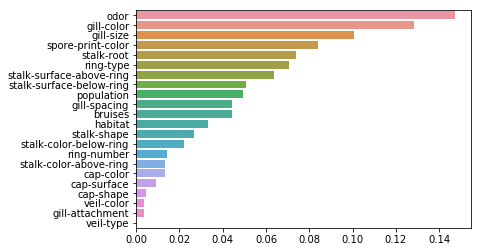

In [40]:
sns.barplot(x=feature_imp, y=feature_imp.index)

In [53]:
#check if removing veil type improves log reg.
# X_train_fi = X_train.drop('veil-type', axis=1)
# X_test_fi = X_test.drop('veil-type', axis=1)
#test for overfitting
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train, y_train)
print("Default RFR: %3.3f" % (dt.score(X_test, y_test)))

NameError: name 'DecisionTreeClassifier' is not defined

In [71]:
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.01, max_depth=1).fit(X_train, y_train)
clf.score(X_test, y_test)  

0.9602132895816243